**Načtení jednotlivých knihoven, se kterými budeme pracovat**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from google.colab import drive
from scipy.stats import multivariate_normal
import numpy as np
import time
import random

**Připojení skriptu k google drive pro získání vstupních dat**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/FAVka/2.ročník/ZSUR/data2.txt'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Načtení souboru s daty**


---


*   otevře soubor na google drive, který obsahuje potřebná data
*   rozdělí jednatlivá data na souřadnice bodů x a y






In [ ]:
x = np.array([])
y = np.array([])

def load(input):
  global x, y
  file = open(input, 'rt')
  for line in file:
      c1, c2 = line.split()
      x = np.append(x, float(c1))
      y = np.append(y, float(c2))

load(file_path)

**Vykreslení bodů z poskytnutých dat**

---



*   pomocí funkce scatter(), která je součástí knihovny matplotlib vykreslíme jednotlivé body



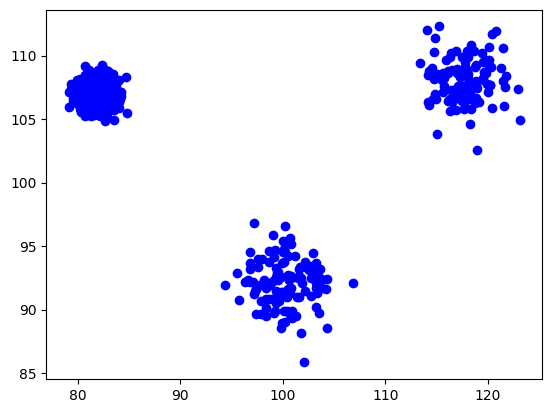

In [ ]:
plt.scatter(x, y, c='blue')
plt.show()

**Vytvoření vektoru bodů a matice nejkratších vzdálenosti mezi jednotlivými body**

---


*   pro metody shlukování, které se nacházejí v dalších buňkách budeme potřebovat znát vzdálenosti mezi jednotlivými body, proto vypočteme pomocí funkce np.linalg.norm() vzdálenosti mezi všemi body, které následně uložíme do matice vzdáleností




In [ ]:
vec_img = np.column_stack((x, y))
matrix = np.zeros((len(vec_img), len(vec_img)))

def Euclidean_distance(x_1, x_2):
    x = x_2 - x_1
    return np.linalg.norm(x)

print("Počítání matice vzdáleností...")
for i in range(len(vec_img)):
    for j in range(i + 1, len(vec_img)):
        dist = Euclidean_distance(vec_img[i], vec_img[j])
        matrix[i, j] = dist

full_matrix = np.triu(matrix) + np.triu(matrix, k=1).T

Počítání matice vzdáleností...


**Posunutí dat**

---



*   posouvá data k nule
*   použito u lineárních klasifikátorů a neuronové sítě



In [ ]:
def shift_data(data):
    x_shift = (np.max(data[:, 0])+np.min(data[:, 0]))/2
    y_shift = (np.max(data[:, 1])+np.min(data[:, 1]))/2
    shifted_data = np.copy(data)
    for i in range(0, len(data)):
        shifted_data[i, 0] -= x_shift
        shifted_data[i, 1] -= y_shift
    return shifted_data


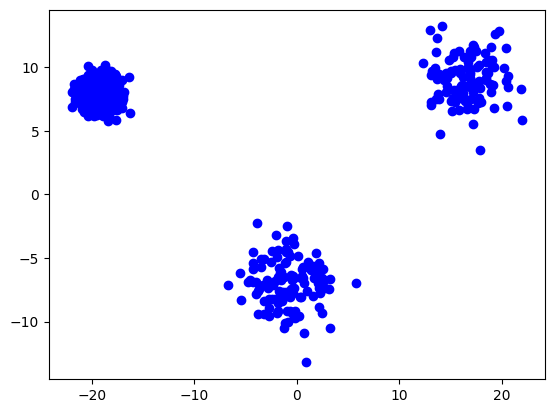

In [ ]:
shifted_vec_img = shift_data(vec_img)
plt.scatter(shifted_vec_img[:,0], shifted_vec_img[:,1], c='blue')
plt.show()

**Matice vzdáleností pro jednotlivé metody**

---



*   protože se v jednotlivých metodách matice vzdáleností může přepisovat musíme vytvořit její kopie, abychom ji nemuseli vždy počítat znovu
*   pomocí zkopírování pole(matice) vytvoříme samostatnou matici vzdáleností pro metodu řetězové mapy
*   pomocí zkopírování pole(matice) vytvoříme samostatnou matici vzdáleností pro metodu MAXIMIN



In [ ]:
matrix_map = np.copy(full_matrix)
matrix_maximin = np.copy(full_matrix)

**Algoritmus shlukové hladiny**

---




*   ze začátku považuje metoda každý bod za jednotlivý shluk, považuje tedy každý řádek v matici vzdáleností za 1 shluk
*   metoda nejdříve najde 2 body v matici, které jsou si nejvíce blízké
*   následně tyto dva body sloučí do jednoho, tím vznikne nový shluk bodů
*   po sloučení metoda vynuluje jeden z řádků a sloupců reprezentující sloučené body a posune ho na konec matice
*   takto pokračuje do té doby dokud je vzádlenost mezi nově vytvořenými shluky menší než 5
*   nakonec v matici zbydou jen body reprezentující finální počet shluků a zbytek matice bude tvořen nulami, počet těchto řádků je roven fínálnímu počtu hledaných shluků

In [ ]:
vektor_hladin = []

for k in range(1, len(vec_img)):
    nonzero_min_position = np.where(full_matrix != 0, full_matrix, np.inf).argmin()
    min_dist = np.unravel_index(nonzero_min_position, full_matrix.shape)
    minimum = np.min(full_matrix[full_matrix != 0])
    vektor_hladin.append(minimum)
    if minimum > 5:
        break

    new_line = []
    print("\r", end="")
    print("Distances counted: " + str(k + 1) + "/" + str(len(vec_img) - 1), end="")

    new_line = np.minimum(full_matrix[min_dist[1], :len(vec_img) - k], full_matrix[min_dist[0], :len(vec_img) - k])

    saved_line = full_matrix[len(vec_img) - k, :]
    saved_culomn = full_matrix[:, len(vec_img) - k]

    full_matrix[min_dist[0], :len(vec_img) - k] = new_line
    full_matrix[:len(vec_img) - k, min_dist[0]] = new_line
    full_matrix[:, min_dist[1]] = saved_culomn
    full_matrix[min_dist[1], :] = saved_line
    full_matrix[:, len(vec_img) - k] = 0
    full_matrix[len(vec_img) - k, :] = 0


cluster_number = np.sum(np.any(full_matrix != 0, axis=1))
print("\nPočet shluků: " + str(cluster_number))

Distances counted: 1109/1110
Počet shluků: 3


**Algoritmus řetězové mapy**

---


*   nejprve inicializujeme index startovního bodu, v našem případě na 30 (výsledek by měl být stejný bez ohledu na starovací index)
*   poté vytvoříme prázdý seznam, do kterého budeme zapisovat vzdáleonosti nejbližších bodů
*   nastavíme počet shluků na začátku na 1
*   projdeme matici vzdáleností a najdeme nejbliží bod k bodu výchozímu, do seznamu vzdáleností zapíšeme jejich vzdálenost
*   pokud bude vzdálenost vyšší než 10, zvýšíme počet shluků o 1
*   původní výchozí bod vynulujeme a místo něj si vezmeme nejbližší bod
*   opakujeme pro všechny body



In [ ]:
x = int(30)
dist_map = []

cluster_number = 1
for k in range(len(vec_img)-1):
    map_line = matrix_map[x, :]
    minimum_map = np.min(map_line[map_line != 0])
    nonzero_min_position_map = np.where(map_line == minimum_map)
    test1 = nonzero_min_position_map[0][0]
    min_dist_map = np.unravel_index(nonzero_min_position_map, matrix_map.shape)
    matrix_map[:, x] = 0

    euc_dist = Euclidean_distance(vec_img[x], vec_img[test1])
    if (euc_dist>10):
        cluster_number=cluster_number+1

    dist_map.append(euc_dist)
    x = test1

print("\nPočet shluků: " + str(cluster_number))


Počet shluků: 3


**Zobrazení grafu řetězové mapy**

---


*   z grafu můžeme dobře vyčíst, kolik shluků budeme mít, podle počtu vzdáleností přesahující 10
*   také můžeme vidět jak jsou od sebe jednotlivé body ve shlucích vzdálené



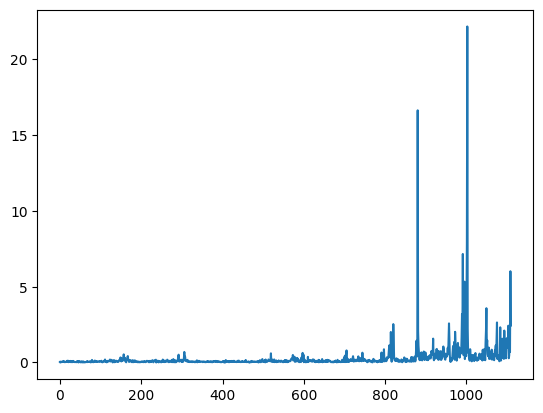

In [ ]:
plt.plot(range(len(dist_map)), dist_map)
plt.show()

**Algoritmus MAXIMIN**

---

*   na začátku algoritmus vybere náhodný bod
*   z matice vzdáleností vybere bod, který je od startovního bodu nejvzdálenejší
*   vytvoříme seznam shluků a přidáme do něj oba body
*   poté vypočteme průměrnou vzdálenost mezi těmito body. kterou poté budeme používat při rozhodování o vytvoření nového shluku
*   vytvoříme matici vzdálenosti aktuálními body a všemi ostatními, pro každý z těchto bodů nalezneme nejbližší vzdálenost k jednoumu ze dvou bodů
*   z těchto minimálních vzdáleností poté hledáme maximální, podle které následně rozhodujeme, jestli bod, ke kterému patří, je v našem limitu(threshold) a přiřadí se do již existujícího shluku nebo se stane novým shlukem
*   metoda poté vrátí počet shluků a indexy bodů, ke kterým byly přiřazovány body v jednotlivých shlucích


In [ ]:
def MAXIMIN_algorithm(matrix, threshold):
  start_img = random.randint(0, len(vec_img))
  next_img = np.argmax(matrix[:,start_img])
  clusters = []
  clusters.append(start_img)
  clusters.append(next_img)
  minimum_vec =[]
  distances = [matrix[start_img, next_img]]
  avg_dist = np.average(distances)
  while(True):
      matrix_clusters = np.zeros((len(clusters), len(vec_img)))
      for j in range(len(clusters)):
        for i in range(len(vec_img)):
          if (i == clusters[j]):
            matrix_clusters[j, i] = 0

            i = i+1
          matrix_clusters[j,i] = matrix[clusters[j],i]
      for i in range(len(vec_img)):
          help_vec = []
          for j in range(len(clusters)):
              help_vec.append(matrix_clusters[j,i])
          minimum_vec.append(min(help_vec))
      maximum = np.argmax(minimum_vec)
      if (max(minimum_vec)<(threshold*avg_dist)):
        clusters.append(maximum)
      else:
        return clusters
      for i in range(len(clusters)):
          distances.append(matrix[maximum,clusters[i]])
      avg_dist = np.average(distances)
  return clusters


threshold_maximin = 1
clusters = MAXIMIN_algorithm(matrix_maximin, threshold_maximin)
result = len(clusters)
print(f'Indexy počátečních bodů jednotlivých shluků: {clusters}')
print(f'Počet shluků: {result}')

Indexy počátečních bodů jednotlivých shluků: [853, 232, 107]
Počet shluků: 3


**Nastavení z MAXIMIN**

---


*   nastaví počet shluků zjištěných z MAXIMIN algoritmu
*   použije pro k-means body, které se každý nachází v jiném shluku z metody MAXIMIN




In [ ]:
clusters = MAXIMIN_algorithm(matrix_maximin, threshold_maximin)
result = len(clusters)
R = result
starter_points = clusters

**Libovolné nastavení**

---


*   možnost nastavení libovolného počtu shluků
*   možnost nastavení libovolných počátečných bodů pro k-means
*   při změně počátečních bodů můžeme pozorovat změnu v počtu iterací



In [ ]:
R = 3
starter_points = [0, 4, 13]

K-means algoritmus s přímým dělením

---
*   do tohoto K-means již používáme body jednotlivých shluků z předchozí metody MAXIMIN
*   ve finální K-means metodě používáme několik předem definovaných metod
*   metoda assign_clusters() přiřadí body k středu shluku, ke kterému je nejblíže
*   metoda update_centers() přepočítá středy shluků jako průměr všech bodů příslušného shluku
*   v samotné metodě poté nastavíme středy na body zjištěné z MAXIMIN algoritmu, následně probíhají jednotlivé iterace skládající se z přiřazení bodů ke středům a přepočítání středů
*   algoritmus skonční pokud se středy přestanou měnit nebo dojde k dosažení maximálního počtu iterací, v tomto případě 100 iterací


Kriterium v 1. iteraci: 12343.689781162402
Kriterium v 2. iteraci: 2961.1402984870765
Počet iterací: 2


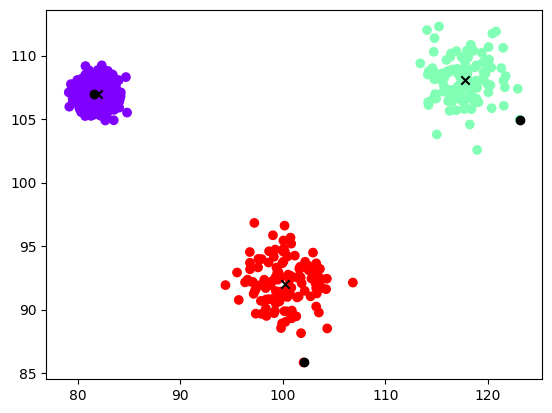

Finální kriterium: 2961.1402984870765
Koncové souřadnice středů shluků:
 [[ 81.99534276 106.99470477]
 [117.74501111 108.08517037]
 [100.17024287  92.01457344]]


In [ ]:
def assign_clusters(vec_img, centers):
    clusters = []
    for point in vec_img:
        distances = np.linalg.norm(point - centers, axis=1)
        closest_center = np.argmin(distances)
        clusters.append(closest_center)
    return np.array(clusters)

def calculate_criterion(data, clusters, centers):
    total_variance = 0
    for i in range(len(centers)):
        cluster_points = data[clusters == i]
        total_variance += np.sum(np.linalg.norm(cluster_points - centers[i], axis=1) ** 2)
    return total_variance

def update_centers(vec_img, clusters, R):
    new_centers = []
    for i in range(R):
        cluster_points = vec_img[clusters == i]
        if len(cluster_points) == 0:
            new_center = vec_img[random.randint(0, len(vec_img)-1)]
        else:
            new_center = np.mean(cluster_points, axis=0)
        new_centers.append(new_center)
    return np.array(new_centers)

def kmeans(vec_img, R, max_iters=100, tol=0):
    centers = vec_img[starter_points]
    for k in range(max_iters):
        clusters = assign_clusters(vec_img, centers)
        initial_criterion = calculate_criterion(vec_img, clusters, centers)
        print(f"Kriterium v {k+1}. iteraci: {initial_criterion}")
        new_centers = update_centers(vec_img, clusters, R)
        if np.allclose(centers, new_centers, atol=tol):
            print(f"Počet iterací: {k+1}")
            break
        centers = new_centers

    return centers, clusters

centers, clusters = kmeans(vec_img, R)
initial_criterion = calculate_criterion(vec_img, clusters, centers)


plt.scatter(vec_img[:, 0], vec_img[:, 1], c=clusters, cmap=plt.cm.rainbow)
plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='x')
plt.scatter(vec_img[starter_points,0], vec_img[starter_points,1], c='black', marker='o')
plt.show()
print(f"Finální kriterium: {initial_criterion}")
print("Koncové souřadnice středů shluků:\n", centers)

**K-means algoritmus s nerovnoměrným binárním dělením**

---


*   ve většině je stejný jako předchozý algoritmus
*   přidáváme metodu initialize_centers()
*   v této metodě začínáme s jedním velkým shlukem, který následně dělíme, v tomto případě jsem zvolil rozdělení shluku podle velikosti jednotlivých shluku, co se týče počtu bodů, to však nedopadlo tak jak bych si představoval, protože shluk v pravo nahoře obsahuje většinu bodů
*   pro každé rozdělení do shluků se provádí zvlášť k-means, poté je ve výpisu možné vidět počet iterací v každém jednom rozdělení
*   ve vykreslení jsou viděte jednotlivé kroky, jak algoritmus rozděluje shluk na další
*   v tomto nesprávném případě je vidět, že rozdělení shluku s hodně body u sebe zabere více iteračních kroků
*   jednotlivé shluky z tohoto postupu jsou označeny jako clusters_size


Kriterium v 1. iteraci: 59670.09352838631
Kriterium v 2. iteraci: 38207.80910080061
Kriterium v 3. iteraci: 35452.21734262333
Kriterium v 4. iteraci: 35450.66800419757
Počet iterací: 4


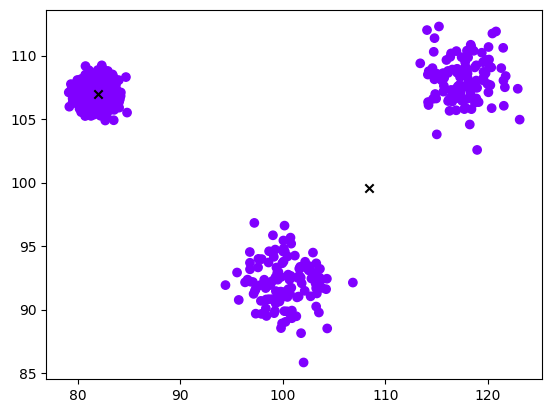

Kriterium v 1. iteraci: 1210.8456416272975
Kriterium v 2. iteraci: 760.7007567612218
Kriterium v 3. iteraci: 730.6671914334045
Kriterium v 4. iteraci: 715.9968176938144
Kriterium v 5. iteraci: 710.2561494552808
Kriterium v 6. iteraci: 707.0271167115002
Kriterium v 7. iteraci: 705.6022056863133
Kriterium v 8. iteraci: 705.3961104573759
Počet iterací: 8


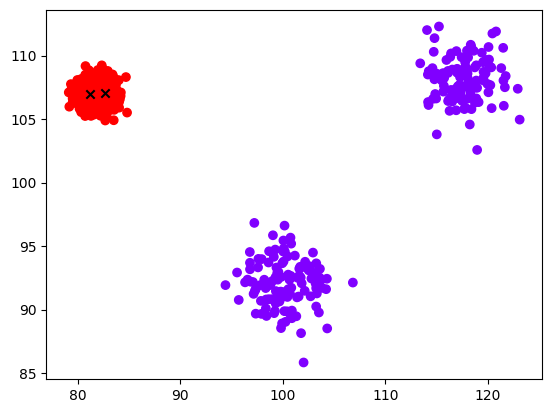

Kriterium v 1. iteraci: 35006.74995566837
Počet iterací: 1


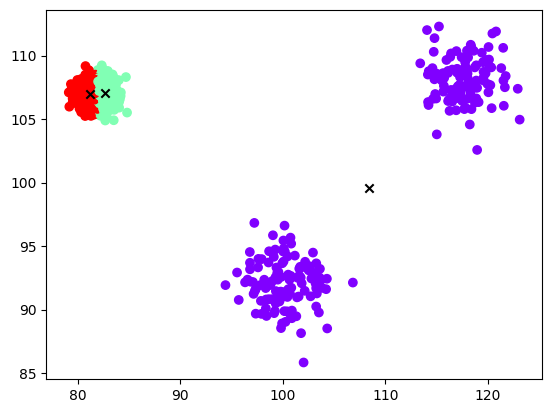

Finální kriterium: 2961.1402984870765
Koncové souřadnice středů shluků:
 [[108.42274274  99.56076678]
 [ 82.64237863 107.0139763 ]
 [ 81.21728212 106.97153075]]


In [ ]:
def initialize_centers(vec_img, R):
    clusters = np.zeros(len(vec_img), dtype=int)

    for i in range(R - 1):
        largest_cluster_idx = np.argmax(np.bincount(clusters))
        largest_cluster_points = vec_img[clusters == largest_cluster_idx]
        initial_centers = largest_cluster_points[random.sample(range(len(largest_cluster_points)), 2)]
        sub_centers, sub_clusters = kmeans(largest_cluster_points, 2, max_iters=10, initial_centers=initial_centers)

        plt.scatter(vec_img[:, 0], vec_img[:, 1], c=clusters, cmap=plt.cm.rainbow)
        plt.scatter(sub_centers[:, 0], sub_centers[:, 1], c='black', marker='x')
        plt.show()

        clusters[clusters == largest_cluster_idx] = sub_clusters + np.max(clusters)

    centers = update_centers(vec_img, clusters, R)
    return centers

def assign_clusters(vec_img, centers):
    clusters = []
    for point in vec_img:
        distances = np.linalg.norm(point - centers, axis=1)
        closest_center = np.argmin(distances)
        clusters.append(closest_center)
    return np.array(clusters)

def update_centers(vec_img, clusters, R):
    new_centers = []
    for i in range(R):
        cluster_points = vec_img[clusters == i]
        if len(cluster_points) == 0:
            new_center = vec_img[random.randint(0, len(vec_img)-1)]
        else:
            new_center = np.mean(cluster_points, axis=0)
        new_centers.append(new_center)
    return np.array(new_centers)

def kmeans(vec_img, R, max_iters=100, tol=0, initial_centers=None):
    if initial_centers is None:
        centers = initialize_centers(vec_img, R)
    else:
        centers = initial_centers

    for k in range(max_iters):
        clusters = assign_clusters(vec_img, centers)
        initial_criterion = calculate_criterion(vec_img, clusters, centers)
        print(f"Kriterium v {k+1}. iteraci: {initial_criterion}")
        new_centers = update_centers(vec_img, clusters, R)
        if np.allclose(centers, new_centers, atol=tol):
            break
        centers = new_centers
    print(f"Počet iterací: {k+1}")
    return centers, clusters

centers, clusters = kmeans(vec_img, 3)

plt.scatter(vec_img[:, 0], vec_img[:, 1], c=clusters, cmap=plt.cm.rainbow)
plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='x')
plt.show()

clusters_size = clusters
print(f"Finální kriterium: {initial_criterion}")
print("Koncové souřadnice středů shluků:\n", centers)

**K-means algoritmus s nerovnoměrným binárním dělením**

---

*   tento přístup na rozdíl od předchozího využívá rozdělení shluku podle nejvzdálenějších bodů místo počtu bodů
*   pomocí tohoto přístupu získáme lepší a požadované výsledky
*   v tomto případě je také vidět značné snížení počtu iterací v posledním kroku
*   jednotlivé shluky z tohoto postupu jsou označeny jako clusters_range
*   při porovnání této metody s přímým dělením, dochází u této metody k většímu počtu iterací

Kriterium v 1. iteraci: 88269.44994391274
Kriterium v 2. iteraci: 43530.54545332811
Kriterium v 3. iteraci: 35474.26874088528
Kriterium v 4. iteraci: 35450.66800419757
Počet iterací: 4


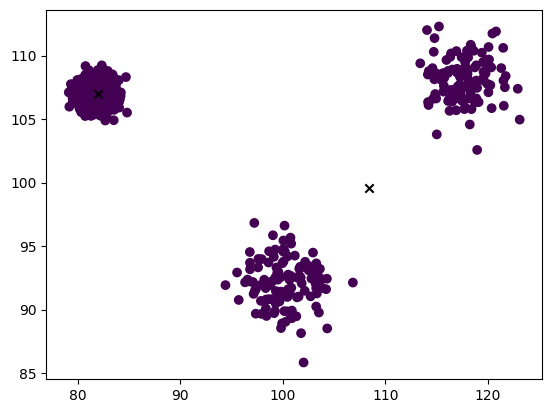

Kriterium v 1. iteraci: 8455.14276019951
Kriterium v 2. iteraci: 1811.8261395005015
Počet iterací: 2


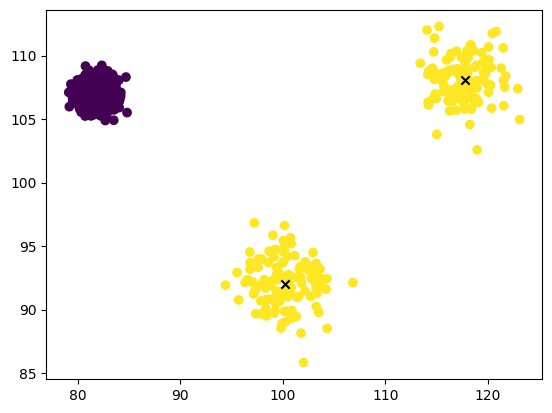

Kriterium v 1. iteraci: 2961.1402984870765
Počet iterací: 1


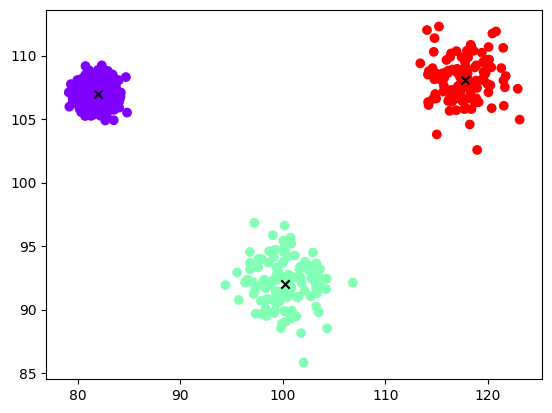

Finální kriterium: 2961.1402984870765
Koncové souřadnice středů shluků:
 [[ 81.99534276 106.99470477]
 [100.17024287  92.01457344]
 [117.74501111 108.08517037]]


In [ ]:
def initialize_centers(vec_img, R):
    clusters = np.zeros(len(vec_img), dtype=int)

    for j in range(R - 1):
        max_distance = 0
        cluster_to_split = 0
        for i in range(np.max(clusters) + 1):
            cluster_points = vec_img[clusters == i]
            if len(cluster_points) > 1:
                distances = np.linalg.norm(cluster_points[:, None, :] - cluster_points[None, :, :], axis=-1)
                current_max_distance = np.max(distances)
                if current_max_distance > max_distance:
                    max_distance = current_max_distance
                    cluster_to_split = i

        cluster_points = vec_img[clusters == cluster_to_split]
        distances = np.linalg.norm(cluster_points[:, None, :] - cluster_points[None, :, :], axis=-1)
        most_distant_pair = np.unravel_index(np.argmax(distances), distances.shape)
        initial_centers = cluster_points[[most_distant_pair[0], most_distant_pair[1]]]
        sub_centers, sub_clusters = kmeans(cluster_points, 2, max_iters=10, initial_centers=initial_centers)

        plt.scatter(vec_img[:, 0], vec_img[:, 1], c=clusters)
        plt.scatter(sub_centers[:, 0], sub_centers[:, 1], c='black', marker='x')
        plt.show()

        clusters[clusters == cluster_to_split] = sub_clusters + np.max(clusters)

    centers = update_centers(vec_img, clusters, R)
    return centers

def assign_clusters(vec_img, centers):
    clusters = []
    for point in vec_img:
        distances = np.linalg.norm(point - centers, axis=1)
        closest_center = np.argmin(distances)
        clusters.append(closest_center)
    return np.array(clusters)

def update_centers(vec_img, clusters, R):
    new_centers = []
    for i in range(R):
        cluster_points = vec_img[clusters == i]
        if len(cluster_points) == 0:
            new_center = vec_img[random.randint(0, len(vec_img)-1)]
        else:
            new_center = np.mean(cluster_points, axis=0)
        new_centers.append(new_center)
    return np.array(new_centers)

def kmeans(vec_img, R, max_iters=100, tol=0, initial_centers=None):
    if initial_centers is None:
        centers = initialize_centers(vec_img, R)
    else:
        centers = initial_centers

    for k in range(max_iters):
        clusters = assign_clusters(vec_img, centers)
        initial_criterion = calculate_criterion(vec_img, clusters, centers)
        print(f"Kriterium v {k+1}. iteraci: {initial_criterion}")
        new_centers = update_centers(vec_img, clusters, R)
        if np.allclose(centers, new_centers, atol=tol):
            print(f"Počet iterací: {k+1}")
            break
        centers = new_centers

    return centers, clusters

centers, clusters = kmeans(vec_img, 3)
plt.scatter(vec_img[:, 0], vec_img[:, 1], c=clusters, cmap=plt.cm.rainbow)
plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='x')
plt.show()

clusters_range = clusters
print(f"Finální kriterium: {initial_criterion}")
print("Koncové souřadnice středů shluků:\n", centers)

**Iterativní optimalizace**

---


*   podobně jako klasický K-means iteruje do té doby než se středy neustálí, tak k-means s iterativní optimalizací iteruje do té doby, než ce kriteriální funkce J nepřestane výrazněji měnit, v tomto případě přestane iterovat pokud rozdíl funkcí je menší než 1
*   jelikož aplikujeme iterativní optimalizaci na již roztřízenou skupinu dat, tak iterace skonční po první, protože rozdíl kriteriálních funkcí je nulový
*   tím můžeme ověřit správnost rozdělení dat do jednotlivých shluků




Kriterium před iterativní optimalizaci: 2961.1402984870765
Iterace: 1, Rozdíl kritérií: 0.0
Počet iterací: 1
Kriterium po iterativní optimalizaci: 2961.1402984870765


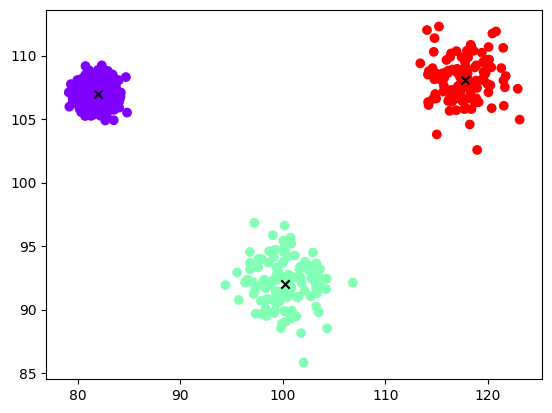

Optimalizované středy shluků:
 [[ 81.99534276 106.99470477]
 [100.17024287  92.01457344]
 [117.74501111 108.08517037]]


In [ ]:
def update_centers(data, clusters, R):
    centers = np.zeros((R, data.shape[1]))
    for i in range(R):
        points_in_cluster = data[clusters == i]
        if len(points_in_cluster) > 0:
            centers[i] = points_in_cluster.mean(axis=0)
    return centers

def calculate_criterion(data, clusters, centers):
    total_variance = 0
    for i in range(len(centers)):
        cluster_points = data[clusters == i]
        total_variance += np.sum(np.linalg.norm(cluster_points - centers[i], axis=1) ** 2)
    return total_variance

def optimize_kmeans(vec_img, clusters, R, max_iters=100, tol=1):

    centers = update_centers(vec_img, clusters, R)
    initial_criterion = calculate_criterion(vec_img, clusters, centers)

    for k in range(max_iters):
        for i in range(len(vec_img)):
            current_label = clusters[i]
            current_point = vec_img[i]
            s_i_k = np.sum(clusters == current_label)
            mu_i_k = centers[current_label]
            new_mu_i = (s_i_k * mu_i_k - current_point) / (s_i_k - 1)
            best_label = current_label
            best_criterion = initial_criterion

            for j in range(R):
                if j == current_label:
                    continue
                s_j_k = np.sum(clusters == j)
                mu_j_k = centers[j]
                new_mu_j = (s_j_k * mu_j_k + current_point) / (s_j_k + 1)
                A_i = s_i_k / (s_i_k - 1) * np.linalg.norm(current_point - mu_i_k) ** 2
                A_j = s_j_k / (s_j_k + 1) * np.linalg.norm(current_point - mu_j_k) ** 2
                if A_j < A_i:
                    temp_clusters = clusters.copy()
                    temp_clusters[i] = j
                    temp_centers = update_centers(vec_img, temp_clusters, R)
                    new_criterion = calculate_criterion(vec_img, temp_clusters, temp_centers)
                    if new_criterion < best_criterion:
                        best_criterion = new_criterion
                        best_label = j

            if best_label != current_label:
                clusters[i] = best_label
                centers = update_centers(vec_img, clusters, R)

        current_criterion = calculate_criterion(vec_img, clusters, centers)
        print(f"Iterace: {k+1}, Rozdíl kritérií: {current_criterion - initial_criterion}")
        if abs(current_criterion - initial_criterion) < tol:
            print(f"Počet iterací: {k+1}")
            break

        initial_criterion = current_criterion

    return centers, clusters
print(f"Kriterium před iterativní optimalizaci: {initial_criterion}")
optimized_centers, optimized_clusters = optimize_kmeans(vec_img, clusters_range, R)
print(f"Kriterium po iterativní optimalizaci: {initial_criterion}")
plt.scatter(vec_img[:, 0], vec_img[:, 1], c=optimized_clusters, cmap=plt.cm.rainbow)
plt.scatter(optimized_centers[:, 0], optimized_centers[:, 1], c='black', marker='x')
plt.show()

print("Optimalizované středy shluků:\n", optimized_centers)


**Bayesův klasifikátor**

---



*   nejprve získáme data pro trénování z předchozí metody, v tomto případě uložené v porměnné clusters_range
*   poté se pro každou třídu vypočte střední hodnota bodů, kovarianční matice a apriorní pravděpodobnost dané třídy
*   poté vypočteme pravděpodobnost, že bod patří do určité třídy za pomocí  multivariate_normal.pdf() funkce a apriorní pravděpodobnosti, kterou již známe z předchozího kroku
*   následně vytvoříme mřížku pro vizualizaci a pro každý bod vypočteme pravděpodobnost
*   vizualizujeme data


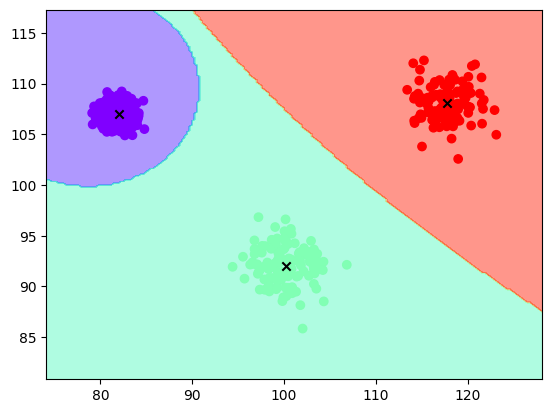

In [ ]:
clusters = clusters_range
unique_clusters = np.unique(clusters)

means = []
covariances = []
priors = []

for cluster in unique_clusters:
    points_in_cluster = vec_img[clusters == cluster]
    means.append(np.mean(points_in_cluster, axis=0))
    covariances.append(np.cov(points_in_cluster.T))
    priors.append(len(points_in_cluster) / len(vec_img))

def posterior(x, means, covariances, priors):
    posteriors = []
    for mean, cov, prior in zip(means, covariances, priors):
        likelihood = multivariate_normal.pdf(x, mean=mean, cov=cov)
        posterior = likelihood * prior
        posteriors.append(posterior)
    return np.array(posteriors)

x, y = np.meshgrid(np.linspace(min(vec_img[:, 0]) - 5, max(vec_img[:, 0]) + 5, 200),
                   np.linspace(min(vec_img[:, 1]) - 5, max(vec_img[:, 1]) + 5, 200))
pos = np.dstack((x, y))
result = np.apply_along_axis(lambda point: np.argmax(posterior(point, means, covariances, priors)), 2, pos)

plt.contourf(x, y, result, alpha=0.5, cmap=plt.cm.rainbow)
plt.scatter(vec_img[:, 0], vec_img[:, 1], c=clusters, cmap=plt.cm.rainbow)
plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='x')
plt.show()

**Vektorová kvantizace**

---



*   v případě vektorové kvantizace pouze rozdělíme mřížku podle toho, k jakému centru je bod mřížky blíže
*   vizualizujeme data



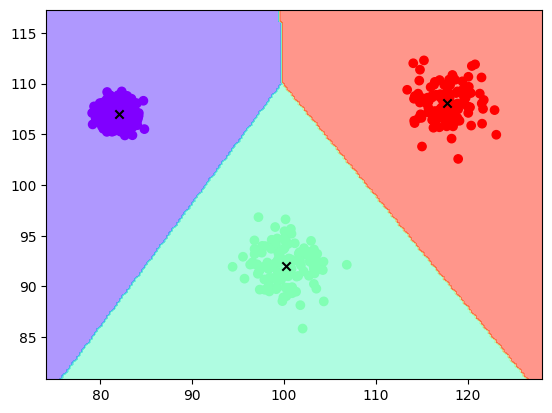

In [ ]:
def predict_vq(point, centers):
    distances = np.linalg.norm(point - centers, axis=1)
    return np.argmin(distances)

x_min, x_max = min(vec_img[:, 0]) - 5, max(vec_img[:, 0]) + 5
y_min, y_max = min(vec_img[:, 1]) - 5, max(vec_img[:, 1]) + 5
x, y = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
pos = np.c_[x.ravel(), y.ravel()]

grid_predictions = np.array([predict_vq(point, centers) for point in pos])
grid_predictions = grid_predictions.reshape(x.shape)

plt.contourf(x, y, grid_predictions, alpha=0.5, cmap=plt.cm.rainbow)
plt.scatter(vec_img[:, 0], vec_img[:, 1], c=clusters, cmap=plt.cm.rainbow)
plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='x')
plt.show()


**Klasifikace podle nejbližšího souseda**


---


*   tato metoda klasifikace se rozhoduje podle určitého počtu nejbližších bodů
*   metoda poredict_knn nejprve určí jaké boudy jsou nejblíže zkoumanému bodu a následně podle počtu sousedů, který nastavíme určí do jaké třídy patří na základě toho v jaké třídě se nachází vatšina sousedů
*   počet sousedů nastavíme parametrem k
*   vizualizujeme data obdobným způsobem jako v předchozí metodě




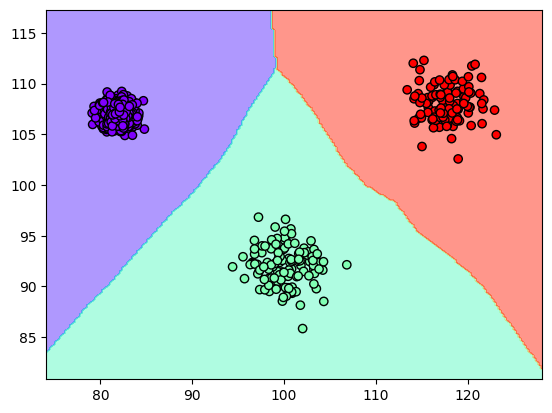

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def predict_knn(point, vec_img, clusters, k):
    distances = np.linalg.norm(point - vec_img, axis=1)
    nearest_neighbors_idxs = np.argsort(distances)[:k]
    nearest_labels = clusters[nearest_neighbors_idxs]

    unique_labels, counts = np.unique(nearest_labels, return_counts=True)
    most_common_label = unique_labels[np.argmax(counts)]

    return most_common_label

# Parametr k - počet sousedů
k = 2

x_min, x_max = min(vec_img[:, 0]) - 5, max(vec_img[:, 0]) + 5
y_min, y_max = min(vec_img[:, 1]) - 5, max(vec_img[:, 1]) + 5
x, y = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
pos = np.c_[x.ravel(), y.ravel()]

grid_predictions = np.array([predict_knn(point, vec_img, clusters, k) for point in pos])
grid_predictions = grid_predictions.reshape(x.shape)

plt.contourf(x, y, grid_predictions, alpha=0.5, cmap=plt.cm.rainbow)
plt.scatter(vec_img[:, 0], vec_img[:, 1], c=clusters, cmap=plt.cm.rainbow, edgecolors='k')
plt.show()


**Klasifikátor s lineární diskriminační funkcí - Rosenblattův algoritmus**

---


*   klasifikotr si nejprve připraví data, na kterých se bude učit, to má na starosti metoda setup_teacher, výstupem bude matice, podle které se bude klasifikátor učit
*   v tomto případě budeme používat Rosenblattův algoritmus(percetron), který bude podle kritéria upravovat váhy a bias, tak, aby kritérium bylo menší než 0, pokud nebude, upraví se váhy a bias a přípočítá se chybná klasifikace
*   poté co algoritmus projede všechny body se vyhodnotí finální chyba a porovná se s přípustnou, pokud bude menší, trénování končí
*   dále se vyhodnotí na základěě skore s použitím natrénovaných paramterů, zda je bod mřířky příslušný k určité třídě nebo nelze zaklasifiovat
*   pokud bude skore pro určitý bod vícekrát kladné, nelze přesně určit do jaké třídy bod spadá a bude obarven bílou barvou
*   vizualizujeme data




Iterace 3333, chyba: 0.0036003600360036
Iterace 6666, chyba: 0.0012001200120012002
Iterace 9999, chyba: 0.0012001200120012002
Iterace 13332, chyba: 0.0012001200120012002
Iterace 16665, chyba: 0.0012001200120012002
Iterace 19998, chyba: 0.0012001200120012002
Iterace 23331, chyba: 0.0009000900090009
Iterace 26664, chyba: 0.00030003000300030005
Iterace 29997, chyba: 0.0009000900090009
Iterace 33330, chyba: 0.00030003000300030005
Iterace 36663, chyba: 0.0
Počet iterací: 36663


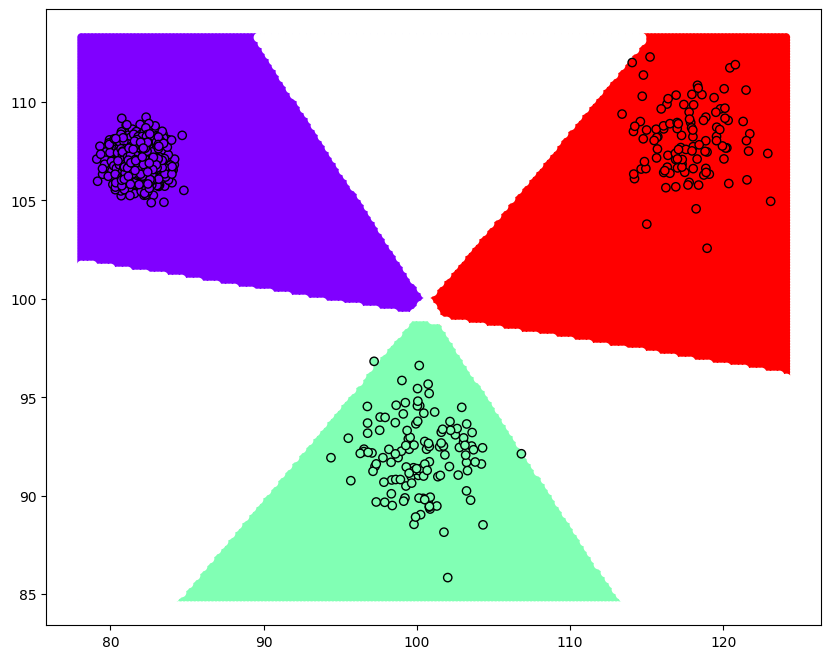

In [ ]:
def setup_teacher(data_train, clusters, classcount):
    teacher = np.zeros((classcount, len(data_train))).astype(int)
    for i in range(classcount):
        for j in range(len(data_train)):
            if clusters[j] == i:
                teacher[i, j] = 1
            else:
                teacher[i, j] = -1
    return teacher

def rosenblatt_train(X, teacher, max_error_rate=0.000001):
    num_features = X.shape[1] - 1
    weights = np.random.uniform(-2, 2, (classcount, num_features))
    biases = np.random.uniform(-2, 2, classcount)
    iterations = 0

    while True:
        total_errors = 0
        for i in range(classcount):
            for j in range(X.shape[0]):
                iterations += 1
                criterium = (np.dot(weights[i, :], X[j, :-1]) + biases[i]) * teacher[i, j]
                if criterium <= 0.0:
                    total_errors += 1
                    weights[i, :] += teacher[i, j] * X[j, :-1]
                    biases[i] += teacher[i, j]

        error_rate = total_errors / (classcount * X.shape[0])
        print(f"Iterace {iterations}, chyba: {error_rate}")
        if error_rate <= max_error_rate:
            break

    return weights, biases, iterations

def predict(data, weights, biases):
    scores = np.dot(data[:, :-1], weights.T) + biases
    predicted_class = np.argmax(scores, axis=1)
    confidence_vector = (np.sum(scores > 0, axis=1) == 1).astype(int)
    return predicted_class, confidence_vector

classcount = len(np.unique(clusters_range))
vec_img_with_bias = np.hstack((shifted_vec_img, np.ones((shifted_vec_img.shape[0], 1))))
teacher = setup_teacher(vec_img_with_bias, clusters_range, classcount)

weights, biases, iterations = rosenblatt_train(vec_img_with_bias, teacher)

print(f'Počet iterací: {iterations}')


x_min, x_max = shifted_vec_img[:, 0].min() - 1, shifted_vec_img[:, 0].max() + 1
y_min, y_max = shifted_vec_img[:, 1].min() - 1, shifted_vec_img[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid_points = np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape)]

Z, confidence = predict(grid_points, weights, biases)
Z = Z.reshape(xx.shape)
confidence = confidence.reshape(xx.shape)

x_min, x_max = vec_img[:, 0].min() - 1, vec_img[:, 0].max() + 1
y_min, y_max = vec_img[:, 1].min() - 1, vec_img[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid_points = np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape)]

unclassified_threshold = 1
unclassified_area = confidence < unclassified_threshold

plt.figure(figsize=(10, 8))
plt.scatter(grid_points[:, 0], grid_points[:, 1], c=Z.ravel(), cmap=plt.cm.rainbow, edgecolor='none')
plt.scatter(xx[unclassified_area == 1], yy[unclassified_area == 1], color='white')
plt.scatter(vec_img[:, 0], vec_img[:, 1], c=clusters_range, cmap=plt.cm.rainbow, edgecolors='k')
plt.show()

**Klasifikátor s lineární diskriminační funkcí - metoda konstantních přírůstků**

---


*   metoda podobná předchozí, jen je změněn způsob trénování klasifikátoru
*   narozdíl od rosenballtaova algoritmu se snažíme kriterium mít větší než 0
*   pokud se kritérium dostane nad 0 algoritmus trénování končí
*   nehlídáme chybu, pouze kritérium
*   můžeme nastavi learing rate
*   vizualizujeme pro několik learning rates


Počet iterací: 3391 pro learning rate 0.01


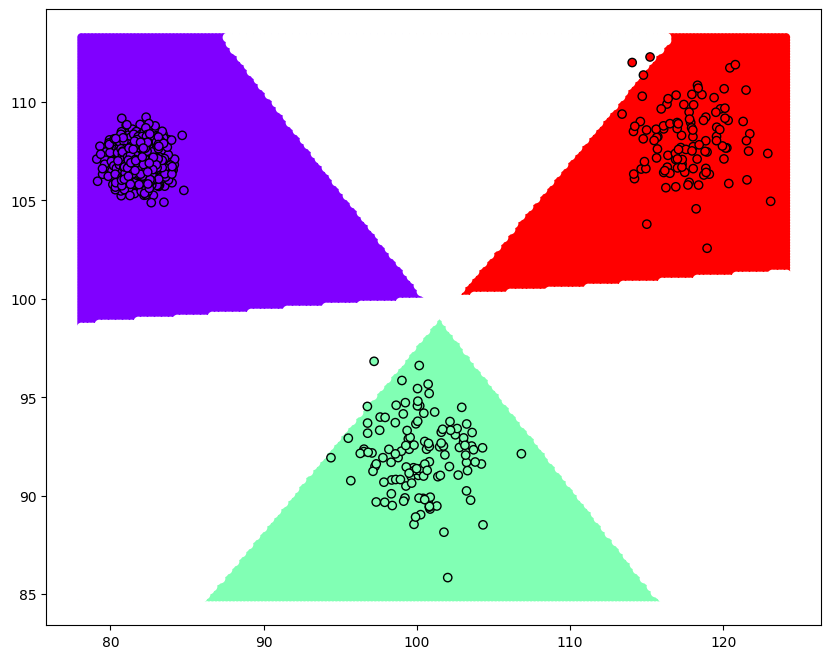

Počet iterací: 3347 pro learning rate 0.1


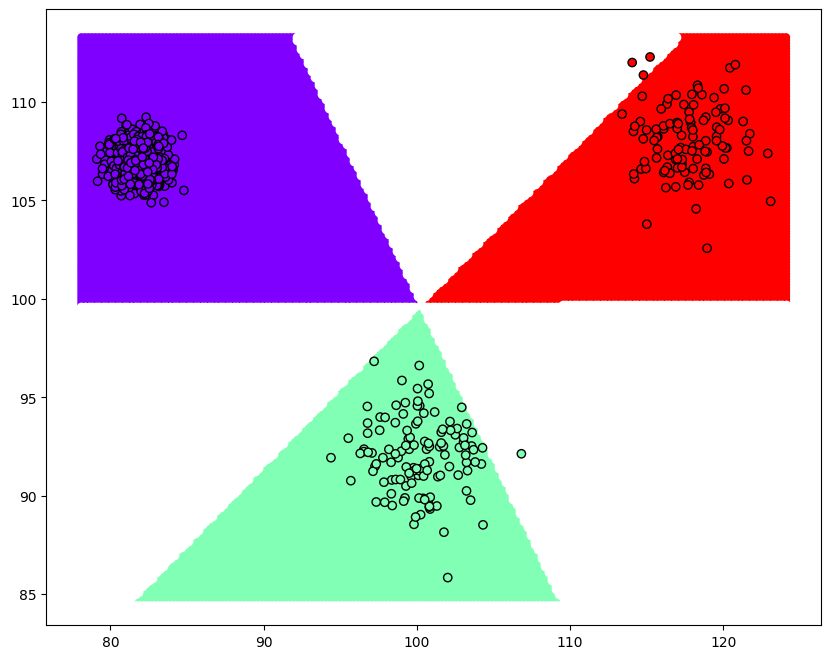

Počet iterací: 3349 pro learning rate 0.5


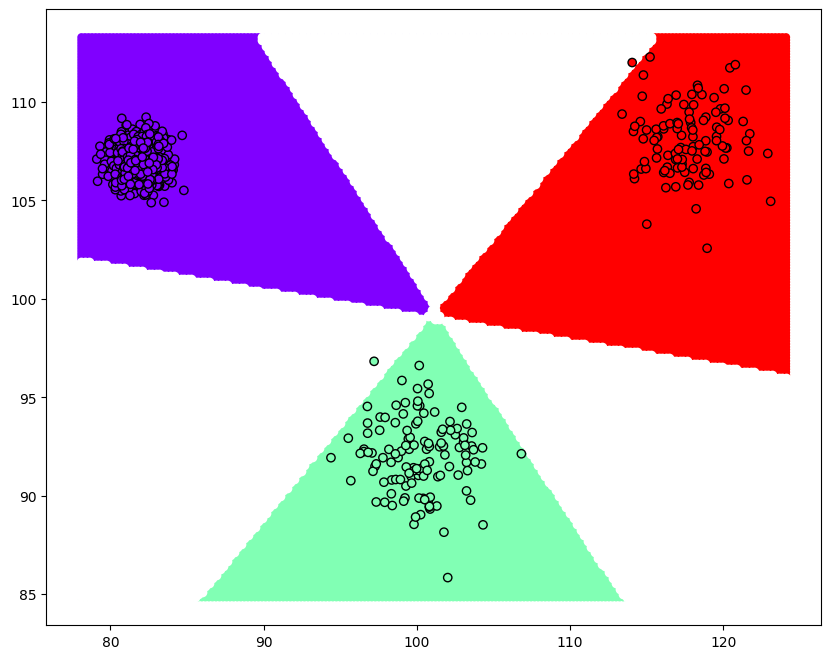

Počet iterací: 3354 pro learning rate 1.0


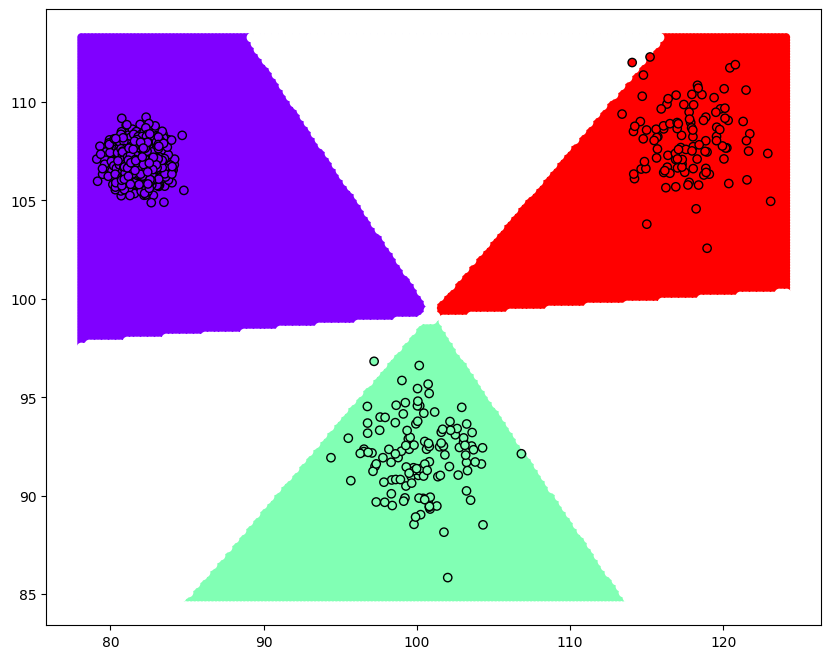

In [ ]:
def setup_teacher(data_train, clusters, classcount):
    """Nastavení učitelské matice pro každou třídu."""
    teacher = np.zeros((classcount, len(data_train))).astype(int)
    for i in range(classcount):
        for j in range(len(data_train)):
            if clusters[j] == i:
                teacher[i, j] = 1
            else:
                teacher[i, j] = -1
    return teacher

def constant_additions_train(X, teacher, learning_rate=0.01):
    num_features = X.shape[1] - 1
    weights = np.random.uniform(-2, 2, (classcount, num_features))
    biases = np.random.uniform(-2, 2, classcount)
    iterations = 0

    for i in range(classcount):
        for j in range(X.shape[0]):
            while True:
                iterations += 1
                criterium = (np.dot(weights[i, :], X[j, :-1]) + biases[i]) * teacher[i, j]
                if criterium >= 0.0:
                    break
                else:
                    weights[i, :] += teacher[i, j] * X[j, :-1] * learning_rate
                    biases[i] += teacher[i, j] * learning_rate
    return weights, biases, iterations

def predict(data, weights, biases):
    scores = np.dot(data[:, :-1], weights.T) + biases
    predicted_class = np.argmax(scores, axis=1)
    confidence_vector = np.zeros(scores.shape[0], dtype=int)
    for i in range(scores.shape[0]):
        positive_indices = np.where(scores[i] > 0)[0]
        if len(positive_indices) == 1:
            confidence_vector[i] = positive_indices[0] + 1
        else:
            confidence_vector[i] = 0
    return predicted_class, confidence_vector

classcount = len(np.unique(clusters_range))
vec_img_with_bias = np.hstack((shifted_vec_img, np.ones((shifted_vec_img.shape[0], 1))))
teacher = setup_teacher(vec_img_with_bias, clusters_range, classcount)

learning_rates = [0.01, 0.1, 0.5, 1.0]

for learning_rate in learning_rates:
    weights, biases, iterations = constant_additions_train(vec_img_with_bias, teacher, learning_rate=learning_rate)

    print(f'Počet iterací: {iterations} pro learning rate {learning_rate}')


    x_min, x_max = shifted_vec_img[:, 0].min() - 1, shifted_vec_img[:, 0].max() + 1
    y_min, y_max = shifted_vec_img[:, 1].min() - 1, shifted_vec_img[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    grid_points = np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape)]

    Z, confidence = predict(grid_points, weights, biases)
    Z = Z.reshape(xx.shape)
    confidence = confidence.reshape(xx.shape)

    x_min, x_max = vec_img[:, 0].min() - 1, vec_img[:, 0].max() + 1
    y_min, y_max = vec_img[:, 1].min() - 1, vec_img[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    grid_points = np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape)]

    unclassified_threshold = 1
    unclassified_area = confidence < unclassified_threshold


    plt.figure(figsize=(10, 8))
    plt.scatter(grid_points[:, 0], grid_points[:, 1], c=Z.ravel(), cmap=plt.cm.rainbow, edgecolor='none')
    plt.scatter(xx[unclassified_area == 1], yy[unclassified_area == 1], color='white')
    plt.scatter(vec_img[:, 0], vec_img[:, 1], c=clusters_range, cmap=plt.cm.rainbow, edgecolors='k')
    plt.show()


**Neuronová síť - SGD**

---



*   nejprve opět nastavíme matici učitele jako v předchozích úlohách
*   poté začneme trénovat síť, nastavíme náhodné váhy a bias
*   poté v každé epoše procházíme jednotlivé body a aplikujeme na ně tzv. Heavisideovou aktivační funkci, která je součástí knihovny numpy
*   trénování končí pokud není rozdíl dat oproti učiteli nebo pokud dosáhneme maximálního počtu epoch, v našem případě 1000
*   po natrénování dostáváme parametry v podobě vah a bias, které poté použijeme obdobným způsobem jako v předchozích případech
*   síť má 2 vrstvy: vstupní a výstupní
*   vstupní vrstva má 2 neurony(souřadnice x a y)
*   výstupní vrstva má počet neuronů roven počtu tříd, v tomto případě 3
*   vizualizujeme data



Počet epoch: 36

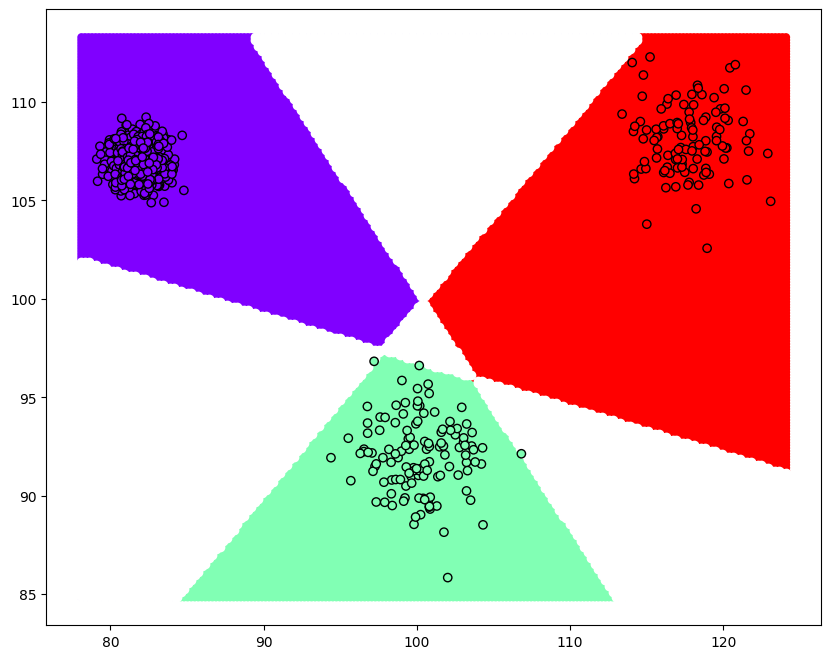

In [ ]:
def setup_teacher(data_train, clusters, classcount):
    teacher = np.zeros((classcount, len(data_train))).astype(int)
    for i in range(classcount):
        for j in range(len(data_train)):
            if clusters[j] == i:
                teacher[i, j] = 1
            else:
                teacher[i, j] = 0
    return teacher

def sgd_train_heaviside(X, teacher, max_iters=1000, learning_rate=0.01):
    num_features = X.shape[1] - 1
    weights = np.random.uniform(-1, 1, (classcount, num_features))
    biases = np.random.uniform(-1, 1, (classcount, 1))
    epochs = 0
    train_again = True
    output = np.zeros((classcount, 1))

    while train_again:
        error_rate = 0
        epochs += 1
        train_again = False
        for j in range(len(X)):
            train_vector = X[j, :-1].reshape(-1, 1)
            output = np.heaviside(np.dot(weights, train_vector) + biases, 1)
            teacher_difference = output - teacher[:, j].reshape(-1, 1)
            if np.any(teacher_difference != 0.0):
                train_again = True
                weights -= learning_rate * np.dot(teacher_difference, train_vector.T)
                biases -= learning_rate * teacher_difference

        if epochs > max_iters:
            train_again = False
        print("\r", end="")
        print("Počet epoch: " + str(epochs), end="")

    return weights, biases, epochs

def predict(data, weights, biases):
    train_vector = data[:, :-1]
    output = np.heaviside(np.dot(train_vector, weights.T) + biases.T, 1)
    predicted_class = np.argmax(output, axis=1)
    confidence_vector = (np.sum(output > 0, axis=1) == 1).astype(int)
    return predicted_class, confidence_vector

classcount = len(np.unique(clusters))
vec_img_with_bias = np.hstack((shifted_vec_img, np.ones((shifted_vec_img.shape[0], 1))))
teacher = setup_teacher(vec_img_with_bias, clusters, classcount)
weights, biases, epochs = sgd_train_heaviside(vec_img_with_bias, teacher)


x_min, x_max = shifted_vec_img[:, 0].min() - 1, shifted_vec_img[:, 0].max() + 1
y_min, y_max = shifted_vec_img[:, 1].min() - 1, shifted_vec_img[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid_points = np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape)]

Z, confidence = predict(grid_points, weights, biases)
Z = Z.reshape(xx.shape)
confidence = confidence.reshape(xx.shape)

unclassified_threshold = 1
unclassified_area = confidence < unclassified_threshold

x_min, x_max = vec_img[:, 0].min() - 1, vec_img[:, 0].max() + 1
y_min, y_max = vec_img[:, 1].min() - 1, vec_img[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid_points = np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape)]

plt.figure(figsize=(10, 8))
plt.scatter(grid_points[:, 0], grid_points[:, 1], c=Z.ravel(), cmap=plt.cm.rainbow, edgecolor='none')
plt.scatter(xx[unclassified_area == 1], yy[unclassified_area == 1], color='white')
plt.scatter(vec_img[:, 0], vec_img[:, 1], c=clusters, cmap=plt.cm.rainbow, edgecolors='k')

**Neuronová síť - batch GD**

---



*   obdobný případ jako v předchozí úloze, jen zde trénujeme na všech datech najednou, oproti předchozímu případu tedy máme rychlejší procházení jednotlivých epoch
*   v tomto případě se ještě vypočítává chyba, která určuje kdy dojde ke zakončení učícího procesu
*   v tomto i v předchozím případě můžeme nastavi rychlost učení (lerning_rate)
*   síť má 2 vrstvy: vstupní a výstupní
*   vstupní vrstva má 2 neurony(souřadnice x a y)
*   výstupní vrstva má počet neuronů roven počtu tříd, v tomto případě 3
*   vizualizace dat



Epocha 4636, chyba: 0.0009000900090009
Počet epoch: 4637


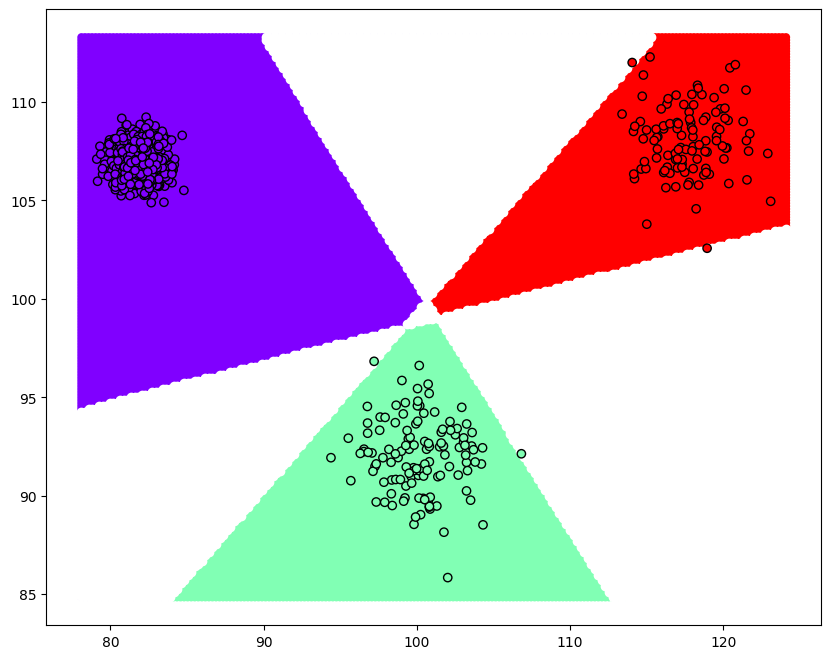

In [ ]:
def setup_teacher(data_train, clusters, classcount):
    teacher = np.zeros((classcount, len(data_train))).astype(int)
    for i in range(classcount):
        for j in range(len(data_train)):
            if clusters[j] == i:
                teacher[i, j] = 1
            else:
                teacher[i, j] = 0
    return teacher

def batch_gd_train_heaviside(X, teacher, max_iters=10000, learning_rate=0.001, error_tolerance=0.000001):
    num_features = X.shape[1] - 1
    weights = np.random.uniform(-1, 1, (classcount, num_features))
    biases = np.random.uniform(-1, 1, (classcount, 1))
    epochs = 0
    train_again = True
    output = np.zeros((classcount, X.shape[0]))

    while train_again:
        epochs += 1
        train_again = False
        outputs = np.heaviside(np.dot(weights, X[:, :-1].T) + biases, 1)
        teacher_difference = outputs - teacher
        error_rate = np.sum(teacher_difference**2) / X.shape[0]
        if error_rate <= error_tolerance:
            break
        if np.any(teacher_difference != 0.0):
            train_again = True
            weights -= learning_rate * np.dot(teacher_difference, X[:, :-1])
            biases -= learning_rate * np.sum(teacher_difference, axis=1, keepdims=True)
        if epochs >= max_iters:
            break
        print(f"\rEpocha {epochs}, chyba: {error_rate}", end="")

    return weights, biases, epochs

def predict(data, weights, biases):
    train_vector = data[:, :-1]
    output = np.heaviside(np.dot(train_vector, weights.T) + biases.T, 1)
    predicted_class = np.argmax(output, axis=1)
    confidence_vector = (np.sum(output > 0, axis=1) == 1).astype(int)
    return predicted_class, confidence_vector

classcount = len(np.unique(clusters))
vec_img_with_bias = np.hstack((shifted_vec_img, np.ones((shifted_vec_img.shape[0], 1))))
teacher = setup_teacher(vec_img_with_bias, clusters, classcount)
weights, biases, epochs = batch_gd_train_heaviside(vec_img_with_bias, teacher, error_tolerance=0.0001)

print(f'\nPočet epoch: {epochs}')


x_min, x_max = shifted_vec_img[:, 0].min() - 1, shifted_vec_img[:, 0].max() + 1
y_min, y_max = shifted_vec_img[:, 1].min() - 1, shifted_vec_img[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid_points = np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape)]


Z, confidence = predict(grid_points, weights, biases)
Z = Z.reshape(xx.shape)
confidence = confidence.reshape(xx.shape)


unclassified_threshold = 1
unclassified_area = confidence < unclassified_threshold

x_min, x_max = vec_img[:, 0].min() - 1, vec_img[:, 0].max() + 1
y_min, y_max = vec_img[:, 1].min() - 1, vec_img[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid_points = np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape)]

plt.figure(figsize=(10, 8))
plt.scatter(grid_points[:, 0], grid_points[:, 1], c=Z.ravel(), cmap=plt.cm.rainbow, edgecolor='none')
plt.scatter(xx[unclassified_area == 1], yy[unclassified_area == 1], color='white')
plt.scatter(vec_img[:, 0], vec_img[:, 1], c=clusters, cmap=plt.cm.rainbow, edgecolors='k')
plt.show()
